# Programming Exercise 4:  Neural Networks Learning

## Introduction

In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.


All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.io import loadmat

## Neural Networks

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

We start the exercise by first loading the dataset. 

In [2]:
# read data and training data stored in arrays X, y
data= loadmat("ex4data1.mat")
X= data["X"]
y= data["y"]
# # set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0
# size of training data
m= y.size

### 1.1 Visualizing the data

You will begin by visualizing a subset of the training set, using the function `display_data`, which is the function we provided below. The dataset is also the same one you used in the previous exercise.

There are 5000 training examples in `ex4data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each
of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 
The following cell randomly selects 100 images from the dataset and plots them.

In [3]:
def display_data(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    100 digits in 10*10 shape
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

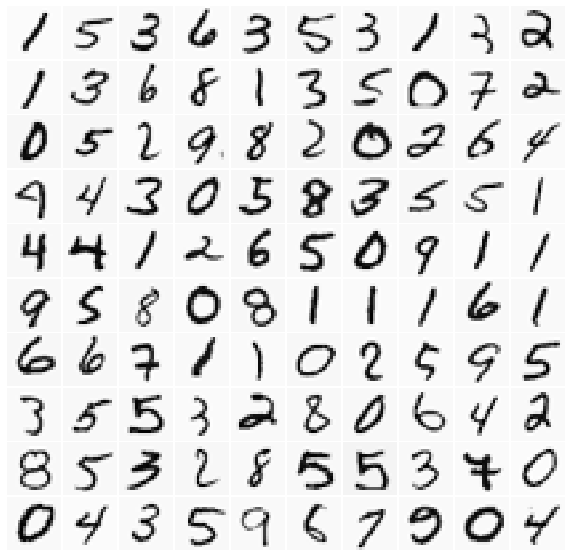

In [4]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
# call display_data to show data
display_data(sel)

### 1.2 Model representation

Our neural network is shown in the following figure.

![](Figures/neural_network.png)

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values
of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables `X` and `y` above.

You have been provided with a set of network parameters ($\Theta^{(1)}, \Theta^{(2)}$) already trained by us. These are stored in `ex4weights.mat` and will be loaded in the next cell of this notebook into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [5]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

weights= loadmat("ex4weights.mat")
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1= weights["Theta1"]
Theta2= weights["Theta2"]
# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)
# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

In [6]:
print("Theta1 Shape is: {}".format(Theta1.shape))
print("Theta2 Shape is: {}".format(Theta2.shape))
print("After concatination of two Theta, neural network parameters are: {}".format(nn_params.shape))

Theta1 Shape is: (25, 401)
Theta2 Shape is: (10, 26)
After concatination of two Theta, neural network parameters are: (10285,)


### 1.3 Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code for the function `nn_cost_function` in the next cell to return the cost.

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).


In [7]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    
    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector 
        or a 2-D matrix. 
    
    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
    """
    # convert every element to numpy array (matrix, vector or scalar)
    z = np.array(z)
    # create free space as size as input 
    g = np.zeros(z.shape)
    # computing sigmoid function
    g = (1 / (1 + np.exp(-z)))
    
    return g

In [8]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)))
    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    a2 = sigmoid(a1.dot(Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
    
    a3 = sigmoid(a2.dot(Theta2.T))
    
    # y is our outputs, we create output vector 
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]
    
    J = (-1 / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix))
    
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    return J, grad

Once you are done, call your `nn_cost_function` using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the cost is about 0.287629.

In [9]:
lambda_ = 0
J, _ = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
print("Cost at parameters (loaded from ex4weights): {:.6f} ".format(J))
print("The cost should be about                   : 0.287629.")

Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.


### 1.4 Regularized cost function

The cost function for neural networks with regularization is given by:


$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

You can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we
have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that your code should in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size. Note that you should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function $J$ using your existing `nn_cost_function` and then later add the cost for the regularization terms.


In [12]:
def nn_cost_function_regularized(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    a2 = sigmoid(a1.dot(Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
    
    a3 = sigmoid(a2.dot(Theta2.T))
    
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]
    
    temp1 = Theta1
    temp2 = Theta2
    
    # Add regularization term
    
    reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])))
    
    J = (-1 / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix)) + reg_term
    
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    return J, grad

Once you are done, the next cell will call your `nn_cost_function_regularized` using the loaded set of parameters for `Theta1` and `Theta2`, and $\lambda = 1$. You should see that the cost is about 0.383770.

In [17]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nn_cost_function_regularized(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

Cost at parameters (loaded from ex4weights): 0.383770
This value should be about                 : 0.383770.
